In [1]:
import time

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

from models import MLP
from shaps import *
from utils import mc_mlp_val, plot_examples_in_a_row, variance_analysis

np.random.seed(3)
os.environ['CUDA_VISIBLE_DEVICES']='1'

## Preprocessing

Download and perform some basic preprocessing to the dataset.

In [2]:
n_features = 28*28

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], n_features)
x_test = x_test.reshape(x_test.shape[0], n_features)

Feature normalization.

In [3]:
x_train = x_train/255
x_test = x_test/255

For convenience we add a bias column to the dataset.

In [4]:
x_train = np.hstack((x_train, np.ones((x_train.shape[0],1))))
x_test = np.hstack((x_test, np.ones((x_test.shape[0],1))))
n_features += 1

## Validate MLP

In [5]:
hidden_layers = range(0, 4)
nodes_hidden_layers = range(25, 500, 25)

max_conf, max_acc = mc_mlp_val(x_train, y_train, n_features, hidden_layers, nodes_hidden_layers, 10)

print(max_acc, max_conf)

100%|██████████| 1000/1000 [6:04:52<00:00, 21.89s/it]  

0.9770666666666667 (785, 450, 25, 10)


## Train MLP

Train and test the best MLP found by the validation procedure.

In [6]:
model = MLP(max_conf, use_bias_input=False)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=50, batch_size=300, validation_split=0, verbose=0)

model.evaluate(x_test, y_test, batch_size=300)

34/34 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.9830


[0.0681378737936393, 0.983]

## Analysis of Variance

Randomly select n examples from the test set. These will be used to compute the Shapely values.

In [7]:
n_examples = 50
example_is = np.random.randint(0, len(x_test), n_examples)
examples = x_test[example_is,:]

Set the number of runs for all the Shapely methods.
The equivalent number of runs will be computed for each method.

In [8]:
runs = 100
runs_per_split = 2

### Owen Sampling Halved

In [9]:
avg_stds_owen_sam_shap_halved = \
    variance_analysis(model, 
                      examples,
                      lambda e, m, y, i: owen_sam_shap_halved(e, m, y, runs=runs_per_split, q_splits=i),
                      runs)

100%|██████████| 50/50 [2:55:30<00:00, 210.61s/it]  


### Owen Sampling

In [10]:
avg_stds_owen_sam_shap = \
    variance_analysis(model, 
                      examples, 
                      lambda e, m, y, i: owen_sam_shap(e, m, y, runs=runs_per_split, q_splits=i),
                      runs)

100%|██████████| 50/50 [2:55:07<00:00, 210.16s/it]  


### Castro Sampling

In [11]:
avg_stds_castro_sam_shap = \
    variance_analysis(model, 
                      examples, 
                      lambda e, m, y, i: castro_sam_shap(e, m, y, runs=i*runs_per_split), 
                      runs)

100%|██████████| 50/50 [4:06:01<00:00, 295.23s/it]  


### Plot

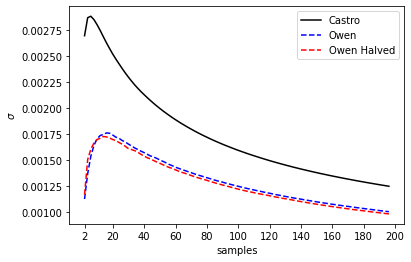

In [12]:
xs = list(np.arange(runs_per_split, (runs-1)*runs_per_split, step=runs_per_split))

plt.plot(xs, avg_stds_castro_sam_shap[2:], 'black', label='Castro')
plt.plot(xs, avg_stds_owen_sam_shap[2:], 'b--', label='Owen')
plt.plot(xs, avg_stds_owen_sam_shap_halved[2:],'r--', label='Owen Halved')
plt.xticks(([2] + list(np.arange(0, runs*runs_per_split+10, step=20)[1:])))
plt.xlabel('samples')
plt.ylabel('$\\sigma$')
plt.legend()
plt.savefig('imgs/variance_analysis_mnist.png', dpi=600)

## Visualization

Let's select 10 digits.

In [13]:
examples = {}

for i, (example, k) in enumerate(zip(x_test, y_test)):
    if k not in examples:
        examples[k] = x_test[i, :]
    if len(examples) == 10:
        break

Set the number of equivalent runs to compute.

In [14]:
runs = 6
runs_per_split = 2

### Plot Digits

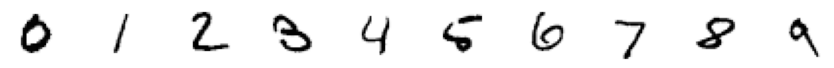

In [15]:
plot_examples_in_a_row(examples, 'Greys')
plt.savefig('imgs/mnist_normal_digits.png', dpi=600)

### Castro (Ground Truth)

In [16]:
phi_gts = {}

for k in tqdm(examples):
    example = examples[k]
    y_hat = np.argmax(model.predict(example[np.newaxis]))
    phi_gt = castro_sam_shap(example, model, y_hat, runs=5000)
    phi_gts[k] = phi_gt

100%|██████████| 10/10 [10:36<00:00, 63.64s/it]


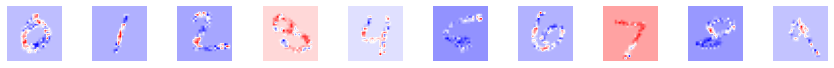

In [17]:
plot_examples_in_a_row(phi_gts)
plt.savefig('imgs/mnist_gt_digits.png', dpi=600)

### Castro

In [18]:
phi_castros = {}

for k in tqdm(examples):
    example = examples[k]
    y_hat = np.argmax(model.predict(example[np.newaxis]))
    phi_castro = castro_sam_shap(example, model, y_hat, runs=runs*runs_per_split)
    if k in phi_castros:
        phi_castros[k] += phi_castro
    else:
        phi_castros[k] = phi_castro

100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


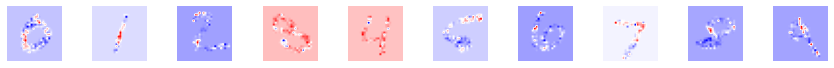

In [19]:
plot_examples_in_a_row(phi_castros)
plt.savefig('imgs/mnist_castro_digits.png', dpi=600)

### Owen

In [20]:
phi_owens = {}

for k in tqdm(examples):
    example = examples[k]
    y_hat = np.argmax(model.predict(example[np.newaxis]))
    phi_owen = owen_sam_shap(example, model, y_hat, runs=runs_per_split, q_splits=runs)
    if k in phi_owens:
        phi_owens[k] += phi_owen
    else:
        phi_owens[k] = phi_owen

100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


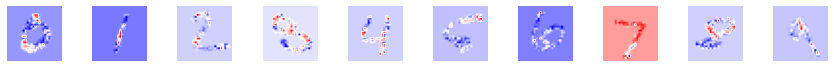

In [21]:
plot_examples_in_a_row(phi_owens)
plt.savefig('imgs/mnist_owen_digits.png', dpi=600)

### Owen Halved

In [22]:
phi_owen_halveds = {}

for k in tqdm(examples):
    example = examples[k]
    y_hat = np.argmax(model.predict(example[np.newaxis]))
    phi_owen_halved = owen_sam_shap_halved(example, model, y_hat, runs=runs_per_split, q_splits=runs)
    if k in phi_owen_halveds:
        phi_owen_halveds[k] += phi_owen_halved
    else:
        phi_owen_halveds[k] = phi_owen_halved

100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


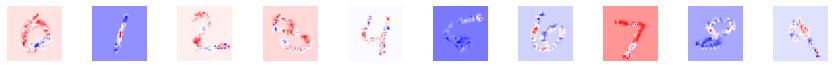

In [23]:
plot_examples_in_a_row(phi_owen_halveds)
plt.savefig('imgs/mnist_owen_halved_digits.png', dpi=600)